In [1]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height: 999999999999 in;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

In [2]:
%matplotlib inline
import ast
import os
import os.path as osp
from glob import glob

from IPython.display import display, Image, Markdown
from ipywidgets import interact, interactive
import ipywidgets as widgets 
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import pickle

from attackgraph import settings
import attackgraph.gambit_analysis as gambit_ops
import attackgraph.common.plot_ops as plot_ops


# Set the font to match AAMAS.
import matplotlib
import matplotlib.font_manager as font_manager
font_dirs = ["/Users/max/Library/Fonts/"]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)
matplotlib.rcParams['font.family'] = "Linux Libertine O"


np.set_printoptions(precision=2)
RESULTS_DIR = settings.get_results_dir()

## Results Table

In [3]:
def parse_metrics_from_output(run_name: str):
    """ Collects the numerical performance of a job from the output log.
    
    :param run_name: Run name.
    :type run_name: str
    """    
    metrics = {}
    filepath = osp.join(RESULTS_DIR, run_name, "out.log")
    print(f"Loading: {filepath}")
    with open(filepath, "r") as output:
        log = [x.strip() for x in output.readlines()]
        
    # Collect the QMix results.
    # 
    # The QMix results will be printed in the following format:
    # 2019-10-21 16:38:55,663 attackgraph INFO Simulating the performance of the QMixture.
    # 2019-10-23 16:08:49,630 attackgraph INFO   - Opponent 0: -143.75378192498087, 42.04794931474071
    # 2019-10-23 16:09:13,042 attackgraph INFO   - Opponent 1: -123.69014674115333, 36.04339825115894
    # 2019-10-23 16:09:37,095 attackgraph INFO   - Opponent 2: -147.11936063662068, 24.261264262023076    
    # 2019-10-23 16:09:37,096 attackgraph INFO Expected reward against mixture opponent: -134.39508007539507
    # 2019-10-23 16:09:37,096 attackgraph INFO Expected std against mixture opponent: 22.526622047220727   
    metrics["QMix"] = {}
    print("  QMix: ")
    in_qmix_section = False
    for line in log:
        # If we're not in the QMix output section, we need to check if we have just entered it.
        if not in_qmix_section:
            # We just entered the QMix section.
            if "Simulating the performance of the QMixture." in line:
                in_qmix_section = True
                continue
            
        # Parse a particular opponent's expected reward.
        if in_qmix_section and "- Opponent" in line:            
            tokens = line.split(' ')
            opponent_id = int(tokens[8].strip(':'))
            mean = float(tokens[-2].strip(','))
            std = float(tokens[-1])            
            metrics["QMix"][opponent_id] = (mean, std)
            print(f"    - {opponent_id}: {mean}, {std}")
            continue
        
        # We've reached the end of the results.
        if in_qmix_section and "Expected reward" in line:
            break
        
    # Collect the BR(Mixture) results.
    # 
    # The section of results looks analogous to QMix, but begins with:
    # 2019-10-21 16:39:18,186 attackgraph INFO Evaluating the best-response trained against mixture opponents on pure-strategy opponents.
    metrics["BR(Mixture)"] = {}
    print("  BR(Mixture): ")
    in_br_section = False
    for line in log:
        # If we're not in the BR(Mix) output section, we need to check if we have just entered it.
        if not in_br_section:
            # We just entered the BR(Mix) section.
            if "Evaluating the best-response trained against mixture opponent" in line:
                in_br_section = True
                continue
            
        # Parse a particular opponent's expected reward.
        if in_br_section and "- Opponent" in line:            
            tokens = line.split(' ')
            opponent_id = int(tokens[8].strip(':'))
            mean = float(tokens[-2].strip(','))
            std = float(tokens[-1])            
            metrics["BR(Mixture)"][opponent_id] = (mean, std)
            print(f"    - {opponent_id}: {mean}, {std}")
            continue
        
        # We've reached the end of the results.
        if in_br_section and "Expected reward" in line:
            break   
            
    # Collect BR(pure-strategy) performance against all opponent strategies. 
    metrics["BR(0)"] = {}
    metrics["BR(1)"] = {}
    metrics["BR(2)"] = {}
    print("  BR(Pure-Strategies): ")
    in_section = False
    for line in log:
        # Determine if we've just entered the right section of the log file.
        if not in_section:
            if "Evaluating pure-strategy-best-response against" in line:
                in_section = True
                continue
        
        # Don't process lines if we're not in the right section.
        if not in_section:
            continue
            
        if "- Opponent" in line:
            tokens = line.split(' ')
            opponent_id = int(tokens[8])
            br_id = int(tokens[11].strip(":"))
            mean = float(tokens[-2].strip(','))
            std = float(tokens[-1])
            metrics[f"BR({br_id})"][opponent_id] = (mean, std)
            print(f"    - BR({br_id}) vs. Opp_{opponent_id}: {mean}, {std}")
            
            
    # TODO(max):
    # Calculate the BR(pi_i) performance against each component pi_j and the mixture.

    return metrics
        

In [4]:
metrics = [parse_metrics_from_output(f"10_25_qmix_def_{i}") for i in range(5)]
mixture = np.array([0.3, 0.5, 0.2])

Loading: /Users/max/projects/attack_graph/attackgraph/../results/10_25_qmix_def_0/out.log
  QMix: 
    - 0: -154.57122721347278, 35.999861826847976
    - 1: -126.94916087423223, 33.262567558810275
    - 2: -135.11201935828046, 17.729404583721156
  BR(Mixture): 
    - 0: -151.0095513602507, 28.997588213014183
    - 1: -65.2680819316003, 16.26004594283119
    - 2: -81.93251673232297, 20.157382593664178
  BR(Pure-Strategies): 
    - BR(0) vs. Opp_0: -118.74800657746657, 25.257169612391497
    - BR(1) vs. Opp_0: -185.8818678644657, 45.19334954208034
    - BR(2) vs. Opp_0: -160.96388953024436, 53.923511633399954
    - BR(0) vs. Opp_1: -193.35253741160747, 21.97609303225822
    - BR(1) vs. Opp_1: -46.494777544671976, 5.718907151438345
    - BR(2) vs. Opp_1: -228.57404995086537, 32.55739600260832
    - BR(0) vs. Opp_2: -125.36731632014711, 15.522568295453066
    - BR(1) vs. Opp_2: -179.98438694547778, 32.1326256016472
    - BR(2) vs. Opp_2: -36.406187119518385, 15.250385121735285
Loading: /Us

In [5]:
# Estimate the performance of both QMix and BR(Mixture) pure-strategies and mixed-strategy.
qmix_results = {}
br_results = {}
ps_results = {}

qmix_means = {0: [], 1: [], 2: []}
qmix_stds = {0: [], 1: [], 2: []}

br_means = {0: [], 1: [], 2: []}
br_stds = {0: [], 1: [], 2: []}

ps0_means = {0: [], 1: [], 2: []}
ps0_stds = {0: [], 1: [], 2: []}

ps1_means = {0: [], 1: [], 2: []}
ps1_stds = {0: [], 1: [], 2: []}

ps2_means = {0: [], 1: [], 2: []}
ps2_stds = {0: [], 1: [], 2: []}
    
for result in metrics:
    for opp_i in range(3):
        # QMix.
        qmix_means[opp_i] += [result["QMix"][opp_i][0]]
        qmix_stds[opp_i] += [result["QMix"][opp_i][1]]
        
        # BR(Mixture).
        br_means[opp_i] += [result["BR(Mixture)"][opp_i][0]]
        br_stds[opp_i] += [result["BR(Mixture)"][opp_i][1]]
        
        # BR(Pure-strategies).
        ps0_means[opp_i] += [result["BR(0)"][opp_i][0]]        
        ps0_stds[opp_i] += [result["BR(0)"][opp_i][1]]
        
        ps1_means[opp_i] += [result["BR(1)"][opp_i][0]]        
        ps1_stds[opp_i] += [result["BR(1)"][opp_i][1]]
        
        ps2_means[opp_i] += [result["BR(2)"][opp_i][0]]        
        ps2_stds[opp_i] += [result["BR(2)"][opp_i][1]]        
        
# Collect the pure-strategy results across each opponent.
ps_qmix_means = []
ps_qmix_stds = []

ps_br_means = []
ps_br_stds = []

ps_ps0_means = []
ps_ps0_stds = []
ps_ps1_means = []
ps_ps1_stds = []
ps_ps2_means = []
ps_ps2_stds = []


for opp_i in range(3):
    print(f"Opponent {opp_i}:")
    
    # QMix.
    mean = np.mean(qmix_means[opp_i])
    std = np.sqrt(np.sum(np.array(qmix_stds[opp_i])**2))
    print(f"  - QMix: {mean}, {std}")
    ps_qmix_means += [mean]
    ps_qmix_stds += [std]
    qmix_results[f"Opp_{opp_i}"] = (mean, std)
    
    # BR(Mixture).
    mean = np.mean(br_means[opp_i])
    std = np.sqrt(np.sum(np.array(br_stds[opp_i])**2))
    print(f"  - BR(Mixture): {mean}, {std}")
    ps_br_means += [mean]
    ps_br_stds += [std]
    br_results[f"Opp_{opp_i}"] = (mean, std)
    
    # BR(Pure-Strategy).
    mean = np.mean(ps0_means[opp_i])
    std = np.sqrt(np.sum(np.array(ps0_stds[opp_i])**2))
    ps_ps0_means += [mean]
    ps_ps0_stds += [std]
    print(f"  - BR(0): {mean}, {std}")
    ps_results[f"BR(0) v Opp_{opp_i}"] = (mean, std)
    
    mean = np.mean(ps1_means[opp_i])
    std = np.sqrt(np.sum(np.array(ps1_stds[opp_i])**2))
    ps_ps1_means += [mean]
    ps_ps1_stds += [std]
    print(f"  - BR(1): {mean}, {std}")
    ps_results[f"BR(1) v Opp_{opp_i}"] = (mean, std)    
    
    mean = np.mean(ps2_means[opp_i])
    std = np.sqrt(np.sum(np.array(ps2_stds[opp_i])**2))
    ps_ps2_means += [mean]
    ps_ps2_stds += [std]
    print(f"  - BR(2): {mean}, {std}")
    ps_results[f"BR(2) v Opp_{opp_i}"] = (mean, std)    
    
print("Mixture:")

# QMix.
mean = np.mean(ps_qmix_means)
std = np.sqrt(np.sum(np.array(ps_qmix_stds)**2))
print(f"  - QMix: {mean}, {std}")
qmix_results["Mix"] = (mean, std)

# BR(Mixture).
mean = np.mean(ps_br_means)
std = np.sqrt(np.sum(np.array(ps_br_stds)**2))
print(f"  - BR(Mixture): {mean}, {std}")
br_results["Mix"] = (mean, std)

# BR(Pure-Strategy)
mean = np.mean(ps_ps0_means)
std = np.sqrt(np.sum(np.array(ps_ps0_stds)**2))
print(f"  - BR(0): {mean}, {std}")
ps_results["BR(0)"] = (mean, std)

mean = np.mean(ps_ps1_means)
std = np.sqrt(np.sum(np.array(ps_ps1_stds)**2))
print(f"  - BR(1): {mean}, {std}")
ps_results["BR(1)"] = (mean, std)

mean = np.mean(ps_ps2_means)
std = np.sqrt(np.sum(np.array(ps_ps2_stds)**2))
print(f"  - BR(2): {mean}, {std}")
ps_results["BR(2)"] = (mean, std)

Opponent 0:
  - QMix: -163.13124813008238, 89.5411361798656
  - BR(Mixture): -151.72270179003405, 73.14250251862532
  - BR(0): -122.32467391401345, 58.978428699990026
  - BR(1): -186.23562185011363, 110.13746966951823
  - BR(2): -164.1824735526324, 121.77334693557883
Opponent 1:
  - QMix: -90.84384661398094, 65.81959457682635
  - BR(Mixture): -64.43269546419565, 44.75249650022364
  - BR(0): -175.75393028764543, 45.573325484516516
  - BR(1): -40.97391102090127, 22.51246727216628
  - BR(2): -213.7028705237038, 69.13720475113632
Opponent 2:
  - QMix: -144.30201043769748, 41.34622912586141
  - BR(Mixture): -88.52863063059127, 43.4703472136375
  - BR(0): -122.35609155170248, 34.621092729306305
  - BR(1): -173.0986905913531, 59.93383278231503
  - BR(2): -36.64053016155007, 23.080383774638552
Mixture:
  - QMix: -132.75903506058694, 118.57210785664248
  - BR(Mixture): -101.56134262827364, 96.13679162819946
  - BR(0): -140.14489858445378, 82.18274216286966
  - BR(1): -133.436074487456, 127.3936

In [6]:
# We will store all of the data into a DataFrame to generate a table.
# Our goal table will look like:
#    Name,    Opp_0,    Opp_1,    Opp_2,    Mixture
#  BR(Opp_0)
#  BR(Opp_1) 
#  BR(Opp_2)
#  BR(Mix)
#  QMix
table = pd.DataFrame(columns=["Name", "Opp_0", "Opp_1", "Opp_2", "Mixture"])

table = table.append({
    "Name": "BR(0)",
    "Opp_0": f"{ps_results['BR(0) v Opp_0'][0]}±{ps_results['BR(0) v Opp_0'][1]}",
    "Opp_1": f"{ps_results['BR(0) v Opp_1'][0]}±{ps_results['BR(0) v Opp_1'][1]}",
    "Opp_2": f"{ps_results['BR(0) v Opp_2'][0]}±{ps_results['BR(0) v Opp_2'][1]}",
    "Mixture": f"{ps_results['BR(0)'][0]}±{ps_results['BR(0)'][1]}"},
    ignore_index=True)
table = table.append({
    "Name": "BR(1)",
    "Opp_0": f"{ps_results['BR(1) v Opp_0'][0]}±{ps_results['BR(1) v Opp_0'][1]}",
    "Opp_1": f"{ps_results['BR(1) v Opp_1'][0]}±{ps_results['BR(1) v Opp_1'][1]}",
    "Opp_2": f"{ps_results['BR(1) v Opp_2'][0]}±{ps_results['BR(1) v Opp_2'][1]}",
    "Mixture": f"{ps_results['BR(1)'][0]}±{ps_results['BR(1)'][1]}"},
    ignore_index=True)
table = table.append({
    "Name": "BR(2)",
    "Opp_0": f"{ps_results['BR(2) v Opp_0'][0]}±{ps_results['BR(2) v Opp_0'][1]}",
    "Opp_1": f"{ps_results['BR(2) v Opp_1'][0]}±{ps_results['BR(2) v Opp_1'][1]}",
    "Opp_2": f"{ps_results['BR(2) v Opp_2'][0]}±{ps_results['BR(2) v Opp_2'][1]}",
    "Mixture": f"{ps_results['BR(2)'][0]}±{ps_results['BR(2)'][1]}"},
    ignore_index=True)

table = table.append({
    "Name": "BR(Mix)",
    "Opp_0": f"{br_results['Opp_0'][0]}±{br_results['Opp_0'][1]}",
    "Opp_1": f"{br_results['Opp_1'][0]}±{br_results['Opp_1'][1]}",
    "Opp_2": f"{br_results['Opp_2'][0]}±{br_results['Opp_2'][1]}",
    "Mixture": f"{br_results['Mix'][0]}±{br_results['Mix'][1]}"},
    ignore_index=True)
table = table.append({
    "Name": "QMix",
    "Opp_0": f"{qmix_results['Opp_0'][0]}±{qmix_results['Opp_0'][1]}",
    "Opp_1": f"{qmix_results['Opp_1'][0]}±{qmix_results['Opp_1'][1]}",
    "Opp_2": f"{qmix_results['Opp_2'][0]}±{qmix_results['Opp_2'][1]}",
    "Mixture": f"{qmix_results['Mix'][0]}±{qmix_results['Mix'][1]}"},
    ignore_index=True)

display(table)

,Name,Opp_0,Opp_1,Opp_2,Mixture
0,BR(0),-122.32467391401345±58.978428699990026,-175.75393028764543±45.573325484516516,-122.35609155170248±34.621092729306305,-140.14489858445378±82.18274216286966
1,BR(1),-186.23562185011363±110.13746966951823,-40.97391102090127±22.51246727216628,-173.0986905913531±59.93383278231503,-133.436074487456±127.39363296437898
2,BR(2),-164.1824735526324±121.77334693557883,-213.7028705237038±69.13720475113632,-36.64053016155007±23.080383774638552,-138.17529141262875±141.9204186150745
3,BR(Mix),-151.72270179003405±73.14250251862532,-64.43269546419565±44.75249650022364,-88.52863063059127±43.4703472136375,-101.56134262827364±96.13679162819946
4,QMix,-163.13124813008238±89.5411361798656,-90.84384661398094±65.81959457682635,-144.30201043769748±41.34622912586141,-132.75903506058694±118.57210785664248


## Learning Curves

In [7]:
run_names = [f"10_25_qmix_def_{i}" for i in range(5)]

Opponent 0: mean_rewards.defender.09_30_egta_dqn_att_epoch1.best_response.pkl


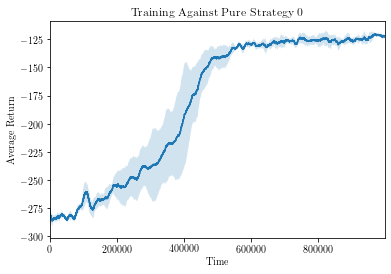

Opponent 1: mean_rewards.defender.09_30_egta_dqn_att_epoch3.best_response.pkl


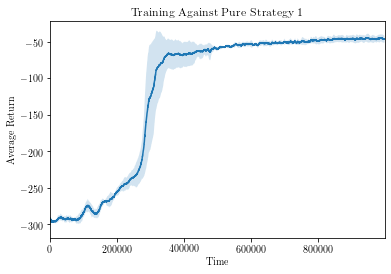

Opponent 2: mean_rewards.defender.09_30_egta_dqn_att_epoch7.best_response.pkl


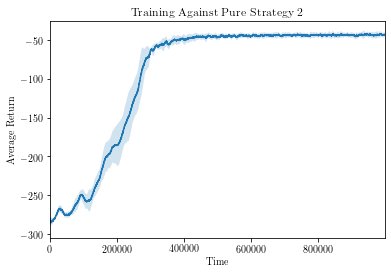

In [8]:
# Print out the pure-strategy learning curves.
reward_filenames = glob(osp.join(osp.join(RESULTS_DIR, run_names[0], "mean_rewards.*.pkl")))
reward_filenames = [osp.basename(x) for x in reward_filenames]
reward_filenames = [x for x in reward_filenames if "mixture" not in x]
reward_filenames = sorted(reward_filenames)

for opp_i, filename in enumerate(reward_filenames):
    print(f"Opponent {opp_i}: {filename}")
    
    # Collect the rewards from each run
    rewards = []
    for run in run_names:
        filepath = osp.join(RESULTS_DIR, run, filename)
        rewards += [pickle.load(open(filepath, "rb"))]
    rewards = np.array(rewards)

    # Calculate the average reward at each timestep.
    reward_mean = np.mean(rewards, axis=0)
    reward_std = np.std(rewards, axis=0)

    fig, ax = plt.subplots()
    
    plt.plot(reward_mean)
    plt.fill_between(
        np.arange(len(reward_mean)), 
        reward_mean-reward_std, 
        reward_mean+reward_std,
        alpha=0.2)
    
    ax.set_xlim([0, len(reward_mean)])
    
    ax.set_title(f"Training Against Pure Strategy {opp_i}")
    ax.set_ylabel("Average Return")
    ax.set_xlabel("Time")
    
    plt.show()

In [1]:
print("Mixture Opponent")

import matplotlib
cmap = matplotlib.cm.get_cmap("Paired")
blue = cmap(0.10)
yellow = cmap(0.80)

# Collect the rewards from each run
rewards = []
for run in run_names:
    filepath = osp.join(RESULTS_DIR, run, "mean_rewards.defender.mixture.best_response.pkl")
    rewards += [pickle.load(open(filepath, "rb"))]
rewards = np.array(rewards)

# Calculate the average reward at each timestep.
reward_mean = np.mean(rewards, axis=0)

fig, ax = plt.subplots(figsize=(5,4), dpi=300)

plt.axhline(y=qmix_results["Mix"][0], color=blue, label="Q-Mixing")
# plt.fill_between(
#     np.arange(len(reward_mean)),
#     np.ones_like(reward_mean)*qmix_results["Mix"][0] - qmix_results["Mix"][1],
#     np.ones_like(reward_mean)*qmix_results["Mix"][0] + qmix_results["Mix"][1],
#     alpha=0.2)

plt.plot(reward_mean, color=yellow, label="BR(Mixture)", linestyle="--", dashes=(10,10))
# plt.fill_between(
#     np.arange(len(reward_mean)), 
#     reward_mean-std, 
#     reward_mean+std,
#     alpha=0.2)

ax.set_xlim([0, len(reward_mean)])

ax.set_title(f"Training Against Mixed Strategy")
ax.set_ylabel("Average Return")
ax.set_xlabel("Time")

ax.legend(loc="lower right", handlelength=4)

plt.show()

Mixture Opponent


AttributeError: module 'matplotlib' has no attribute 'cm'